# 2段階のNLモデルの構築
上位：私事トリップ選択モデル（しないor義務or裁量）  
下位：端末選択モデル
### 5との違い
- ネストパラメータの導入方法が異なる

In [1]:
# ライブラリの導入
# ライブラリの導入
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Noto Sans CJK JP"  # 日本語入力対応
import time

import biogeme.biogeme_logging as blog

from biogeme.database import Database
from biogeme.expressions import Variable, Beta
from biogeme.biogeme import BIOGEME
from biogeme.models import lognested
from biogeme.models import nested
from biogeme.nests import OneNestForNestedLogit, NestsForNestedLogit
from biogeme.results_processing import get_pandas_estimated_parameters

/home/shibumtk/B4research/estimate/.venv/lib/python3.12/site-packages/tqdm_joblib/__init__.py:4: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
# 入力データの読み込み
master_df = pd.read_csv("/home/shibumtk/B4research/estimate/data/NL_data/c_NL_Logit_master2.csv", encoding="utf-8-sig")
master_df = master_df.fillna(0) # 欠損値を一応埋める

# 文字列は除外する
drop_cols =['NearestStation', 'WorkplaceStation']
master_df = master_df.drop(columns=drop_cols)

# 女性データの抽出
master_df = master_df[master_df['sex'] == 2].copy()

# 確認
print(len(master_df))
master_df.columns

16388


Index(['Personal_ID', 'HouseholdIncome', 'sex', 'age', 'JobType',
       'ComuTime[m]', 'MainlineTime[m]', 'AccessTime_used[m]', 'HouseholdType',
       'HouseholdMembers(all)', 'YoungestMember_No', 'WorkTime[m]',
       'AfterTime_work[m]', 'AfterTime_home[m]', 'first_transportation',
       'NearestStation_code', 'near_chuko_area300', 'near_chuko_area1000',
       'near_300index1', 'near_1000index1', 'near_300index2',
       'near_1000index2', 'WorkplaceStation_code', 'WP_chuko_area300',
       'WP_chuko_area1000', 'WP_300index1', 'WP_1000index1', 'WP_300index2',
       'WP_1000index2', 'PriTrip', 'timing', 'FacilityType', 'TripPurpose',
       'PriTrip_class', 'StayTime', 'walk_av', 'walk_time[m]', 'bicycle_av',
       'bicycle_time[m]', 'bicycle_parking_fee', 'bus_av', 'bus_time[m]',
       'bus_cost', 'dist_nearest_BusStop[km]', 'car_av', 'car_time[m]',
       'car_cost'],
      dtype='object')

In [3]:
# NL用のCHOICEカラムを作成
mode_map = {1:0, 2:1, 4:2, 5:3} # 端末手段を0~3にまとめる
# 端末手段のカラムを書き換え（新しいカラムを作成）
master_df["t_first_transportation"] = master_df["first_transportation"].map(mode_map)

df = master_df.copy()
# CHOICEカラム
df['CHOICE9'] = np.select(
    [df['PriTrip_class'] == 0, df['PriTrip_class'] == 1, df['PriTrip_class'] == 2],
    [1, 2 + df['t_first_transportation'], 6 + df['t_first_transportation']]
).astype("int64")

t_master_df = df.copy()

# 確認
print(t_master_df['CHOICE9'].value_counts().sort_index().sum())
t_master_df['CHOICE9'].value_counts().sort_index()

16388


CHOICE9
1    11975
2     1851
3      305
4      183
5       41
6     1662
7      168
8      159
9       44
Name: count, dtype: int64

In [4]:
# 可用性の分布
t_master_df[['walk_av','bicycle_av','bus_av','car_av']].value_counts().sort_index()

walk_av  bicycle_av  bus_av  car_av
1        0           0       0         3848
                             1          926
                     1       0          719
                             1          582
         1           0       0         3921
                             1         2672
                     1       0         1518
                             1         2202
Name: count, dtype: int64

In [5]:
# biogemeデータリストに格納する
master_db = Database("PTdata", t_master_df)

In [6]:
# ==============
# 変数定義
# ==============
CHOICE = Variable("CHOICE9")

# availability & time
WA_AV = Variable("walk_av")
WA_TT = Variable("walk_time[m]")

BI_AV = Variable("bicycle_av")
BI_TT = Variable("bicycle_time[m]")

BU_AV = Variable("bus_av")
BU_TT = Variable("bus_time[m]")

CA_AV = Variable("car_av")
CA_TT = Variable("car_time[m]")

# Trip-level covariates
WORKTIME    = Variable("WorkTime[m]")
AF_WORKTIME = Variable("AfterTime_work[m]") # AF=after
MACMTIME    = Variable("MainlineTime[m]")
HHM_all     = Variable("HouseholdMembers(all)")
NEKI_INDEX  = Variable("near_1000index2")
WEKI_INDEX  = Variable("WP_1000index2") # 就業地駅土地利用指標

# scaled
WORKTIME_SCALED    = master_db.define_variable("WORKTIME_SCALED", WORKTIME / 60)
AF_WORKTIME_SCALED = master_db.define_variable("AF_WORKTIME_SCALED", AF_WORKTIME / 60)
MACMTIME_SCALED    = master_db.define_variable("MACMTIME_SCALED", MACMTIME / 60)
NEKI_SCALED        = master_db.define_variable("NEKI_SCALED", NEKI_INDEX / 1_000_000)
WEKI_SCALED        = master_db.define_variable("WEKI_SCALED", WEKI_INDEX / 1_000_000)

# ==============
# パラメータ
# ==============
# モード側ASC（walk基準）
ASC_BI = Beta("ASC_BI", 0, None, None, 0)
ASC_BU = Beta("ASC_BU", 0, None, None, 0)
ASC_CA = Beta("ASC_CA", 0, None, None, 0)

# 端末時間係数（共通変数）
b_at = Beta("b_at", 0, None, None, 0)

# Trip-type（Duty/Disc）側
ASC_DU = Beta("ASC_DU", 0, None, None, 0)
ASC_DI = Beta("ASC_DI", 0, None, None, 0)

# 独立に導入する説明変数
b_work_du        = Beta("b_work_du", 0, None, None, 0)
b_macmtime_du    = Beta("b_macmtime_du", 0, None, None, 0)
b_n_eki_du       = Beta("b_n_eki_du", 0, None, None, 0)
b_w_eki_du       = Beta("b_w_eki_du", 0, None, None, 0)
b_hhm_du         = Beta("b_hhm_du", 0, None, None, 0)

b_work_di        = Beta("b_work_di", 0, None, None, 0)
b_macmtime_di    = Beta("b_macmtime_di", 0, None, None, 0)
b_n_eki_di       = Beta("b_n_eki_di", 0, None, None, 0)
b_w_eki_di       = Beta("b_w_eki_di", 0, None, None, 0)
b_hhm_di         = Beta("b_hhm_di", 0, None, None, 0)

# 共通変数
b_aftime_work = Beta("b_aftime_work", 0, None, None, 0)

# ネストパラメータ（NoTripは単一代替なので固定=1）
# NoTripは単一代替なら μ を置いても効かないので固定でOK
MU_NO = Beta("MU_NO", 1.0, 1.0, 1.0, 1)

# λを推定
LAMBDA_DU = Beta("LAMBDA_DU", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
LAMBDA_DI = Beta("LAMBDA_DI", 0.8, 0.01, 1.0, 0)  # (0,1]に制約
MU_DU = 1 / LAMBDA_DU
MU_DI = 1 / LAMBDA_DI

# ==============
# 代替ID（9択）
# ==============
NO      = 1
DU_WA   = 2
DU_BI   = 3
DU_BU   = 4
DU_CA   = 5
DI_WA   = 6
DI_BI   = 7
DI_BU   = 8
DI_CA   = 9

# ==============
# 効用
# NoTripは基準：0
# ==============
V_NO = 0

# Trip-type utility（Duty/Disc）
V_DU_PRI = (ASC_DU
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_du * MACMTIME_SCALED
            + b_n_eki_du    * NEKI_SCALED
            + b_hhm_du      * HHM_all)

V_DI_PRI = (ASC_DI
            + b_aftime_work * AF_WORKTIME_SCALED
            + b_macmtime_di * MACMTIME_SCALED
            + b_n_eki_di    * NEKI_SCALED
            + b_hhm_di      * HHM_all)

# Mode utility（walk基準でASC=0）
V_WA_MODE = b_at * WA_TT
V_BI_MODE = ASC_BI + b_at * BI_TT
V_BU_MODE = ASC_BU + b_at * BU_TT
V_CA_MODE = ASC_CA + b_at * CA_TT

# 9 alternatives utilities
V = {
    NO:    V_NO,

    DU_WA: V_DU_PRI + V_WA_MODE,
    DU_BI: V_DU_PRI + V_BI_MODE,
    DU_BU: V_DU_PRI + V_BU_MODE,
    DU_CA: V_DU_PRI + V_CA_MODE,

    DI_WA: V_DI_PRI + V_WA_MODE,
    DI_BI: V_DI_PRI + V_BI_MODE,
    DI_BU: V_DI_PRI + V_BU_MODE,
    DI_CA: V_DI_PRI + V_CA_MODE
}

# availability（NoTripは常に利用可能=1）
av = {
    NO: 1,

    DU_WA: WA_AV,
    DU_BI: BI_AV,
    DU_BU: BU_AV,
    DU_CA: CA_AV,

    DI_WA: WA_AV,
    DI_BI: BI_AV,
    DI_BU: BU_AV,
    DI_CA: CA_AV,
}

# ==============
# nests（上位＝{NoTrip, Duty, Discretion}）
# ==============
nest_no = OneNestForNestedLogit(MU_NO, [NO], name="NoTrip")
nest_du = OneNestForNestedLogit(MU_DU, [DU_WA, DU_BI, DU_BU, DU_CA], name="Duty")
nest_di = OneNestForNestedLogit(MU_DI, [DI_WA, DI_BI, DI_BU, DI_CA], name="Discretion")

nests = NestsForNestedLogit(
    choice_set=list(V.keys()),
    tuple_of_nests=(nest_no, nest_du, nest_di)
)

In [ ]:
# loglikelihood
logprob = lognested(V, av, nests, CHOICE)

# estimate
logger = blog.get_screen_logger(level=blog.INFO)
biogeme = BIOGEME(
    master_db,
    logprob,
    generate_html=False,
    generate_yaml=False,
    optimization_algorithm="simple_bounds_BFGS",
    calculating_second_derivatives="never", 
    save_iterations=False
)
biogeme.model_name = "NL_NoTrip0_DutyDisc_Mode2"

biogeme.calculate_null_loglikelihood(av)
results = biogeme.estimate()
print("estimate() returned") 
print(results.short_summary())

# パラメータ推定値をpandasに格納して表示
pandas_results = get_pandas_estimated_parameters(estimation_results=results)
print(pandas_results.to_string)

Biogeme parameters read from biogeme.toml. 
Starting values for the algorithm: {} 
Optimization algorithm: BFGS with simple bounds [simple_bounds_BFGS]. 
Optimization algorithm: hybrid Newton/BFGS with simple bounds [simple_bounds] 
** Optimization: BFGS with trust region for simple bounds 
E0118 22:46:33.333641   50980 slow_operation_alarm.cc:73] 
********************************
[Compiling module jit_sum_function for CPU] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [ ]:
pandas_results.to_csv("/home/shibumtk/B4research/estimate/data/results/NL_2nest_estimated_parameters6_female.csv", index=False, encoding="utf-8-sig")
print("saved: estimated_parameters6_female.csv")

saved: estimated_parameters6.csv


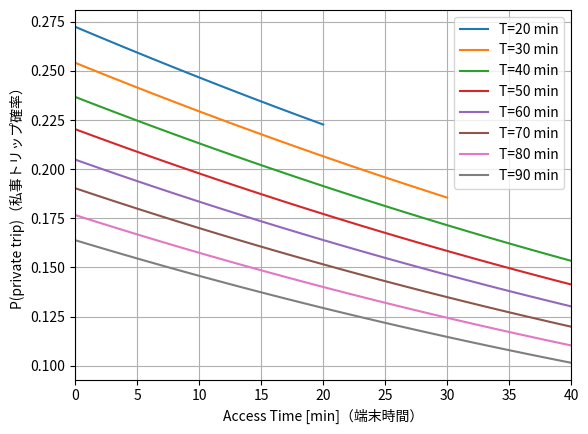

In [18]:
# 全ての端末時間と通勤メイン時間を変化させた場合
# ========= 1) 推定値の読み込み =========
b = results.get_beta_values()  # dict: 推定パラメータ

# 便利関数：安定な sigmoid
def sigmoid(z):
    z = np.asarray(z)
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[~pos])
    out[~pos] = ez / (1.0 + ez)
    return out

# log(exp(a)+exp(b)) を安定に計算
def logsumexp2(a, b):
    m = np.maximum(a, b)
    return m + np.log(np.exp(a - m) + np.exp(b - m))

# ========= 2) 平均値で固定する共変量 =========
df = master_df.copy()

# scaled列があるならそれを優先、無ければ元列から計算
AF_mean   = df["AfterTime_work[m]"].mean()/ 60
NEKI_mean = df["near_1000index2"].mean() / 1_000_000
HHM_mean  = 2 # 世帯人数

# ========= 3) モード側 logsum 部分（端末時間 a を全モード共通に置く仮定） =========
# V_mode_WA = b_at * a
# V_mode_BI = ASC_BI + b_at * a, etc.
# sum_k exp(mu*(ASC_k + b_at*a)) = exp(mu*b_at*a) * (1 + exp(mu*ASC_BI)+exp(mu*ASC_BU)+exp(mu*ASC_CA))
# (1/mu)*log(sum...) = b_at*a + (1/mu)*log(1 + exp(mu*ASC_BI)+exp(mu*ASC_BU)+exp(mu*ASC_CA))

def mode_logsum_term(mu, a):
    S = (
        1.0
        + np.exp(mu * b["ASC_BI"])
        + np.exp(mu * b["ASC_BU"])
        + np.exp(mu * b["ASC_CA"])
    )
    return b["b_at"] * a + (1.0 / mu) * np.log(S)

# ========= 4) Inclusive value IV_DU, IV_DI =========
# 本線時間 = T - a（分）→ MACMTIME_SCALED = (T-a)/60
def IV_DU(a, T):
    main_scaled = (T - a) / 60.0
    Vpri = (
        b["ASC_DU"]
        + b["b_aftime_work"] * AF_mean
        + b["b_macmtime_du"] * main_scaled
        + b["b_n_eki_du"] * NEKI_mean
        + b["b_hhm_du"] * HHM_mean
    )
    mu = 1 / b["LAMBDA_DU"]
    return Vpri + mode_logsum_term(mu, a)

def IV_DI(a, T):
    main_scaled = (T - a) / 60.0
    Vpri = (
        b["ASC_DI"]
        + b["b_aftime_work"] * AF_mean
        + b["b_macmtime_di"] * main_scaled
        + b["b_n_eki_di"] * NEKI_mean
        + b["b_hhm_di"] * HHM_mean
    )
    mu = 1 / b["LAMBDA_DI"]
    return Vpri + mode_logsum_term(mu, a)

# ========= 5) P(private)=P(DU)+P(DI) =========
# P(private) = (exp(IV_DU)+exp(IV_DI)) / (1 + exp(IV_DU)+exp(IV_DI))
#           = sigmoid( log(exp(IV_DU)+exp(IV_DI)) )
def P_private(a, T):
    iv_du = IV_DU(a, T)
    iv_di = IV_DI(a, T)
    L = logsumexp2(iv_du, iv_di)   # = log( exp(IV_DU)+exp(IV_DI) )
    return sigmoid(L)

# ========= 6) 描画 =========
T_list = list(range(20, 91, 10))  # 20,30,...,90
x_max = 40                        # 図に合わせて 0〜40 分を表示

plt.figure()
for T in T_list:
    a_grid = np.arange(0, min(T, x_max) + 1)  # a=0..min(T,40)
    p_grid = P_private(a_grid, T)
    plt.plot(a_grid, p_grid, label=f"T={T} min")

plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Access Time [min]（端末時間）")
plt.ylabel("P(private trip)（私事トリップ確率）")
plt.show()

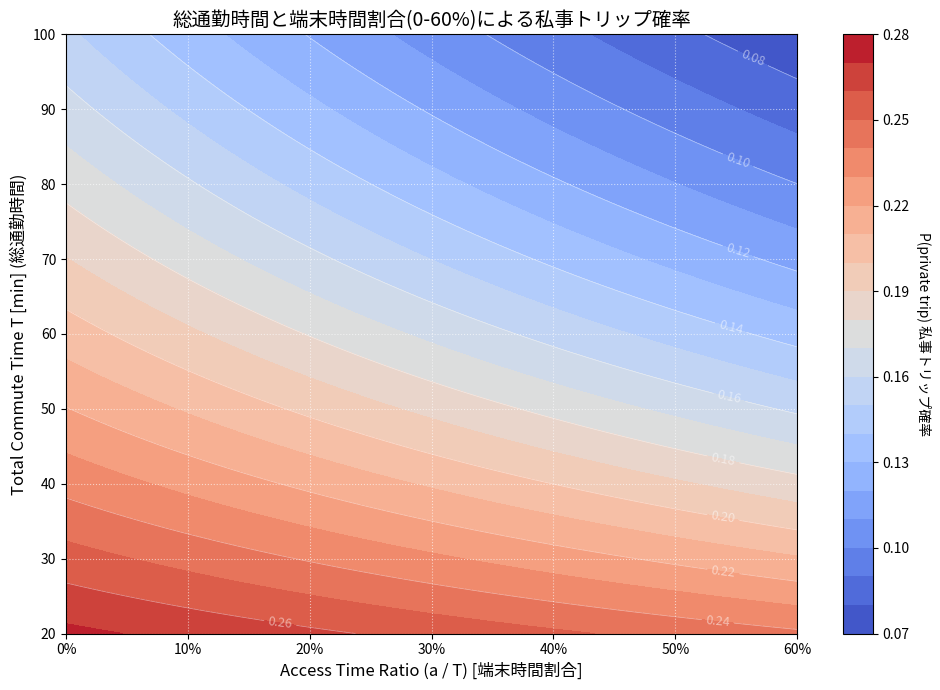

In [20]:
# 縦軸：総通勤時間 T (20分〜100分)
T_vals = np.linspace(20, 100, 100)

# 横軸：端末時間の割合 Ratio (0.0 〜 0.6)
R_vals = np.linspace(0, 0.6, 100)

# メッシュグリッド作成
RR, TT = np.meshgrid(R_vals, T_vals)

# 端末時間 a を計算 (a = 総時間 * 割合)
AA = TT * RR

# 私事トリップ確率を一括計算
# ここで定義した P_private に配列 AA, TT を渡すと
# 内部の IV_DU 等も配列計算を行い、結果(PP)も (100,100) の配列になります
PP = P_private(AA, TT)

# =========================================================
# 5) 描画
# =========================================================
plt.figure(figsize=(10, 7))

# ヒートマップ (等高線充填)
# cmap='viridis' や 'coolwarm', 'plasma' などお好みで
cp = plt.contourf(RR, TT, PP, levels=20, cmap='coolwarm')

# 数値を読み取るための白い等高線
line_c = plt.contour(RR, TT, PP, levels=10, colors='white', alpha=0.5, linewidths=0.5)
plt.clabel(line_c, inline=True, fontsize=9, fmt='%.2f')

# 横軸のフォーマット (0.6 -> 60%)
import matplotlib.ticker as ticker
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1.0))

# カラーバー
cbar = plt.colorbar(cp)
cbar.set_label('P(private trip) 私事トリップ確率', rotation=270, labelpad=15)

# ラベル
plt.title("総通勤時間と端末時間割合(0-60%)による私事トリップ確率", fontsize=14)
plt.xlabel("Access Time Ratio (a / T) [端末時間割合]", fontsize=12)
plt.ylabel("Total Commute Time T [min] (総通勤時間)", fontsize=12)

# グリッド
plt.grid(True, linestyle=':', alpha=0.6, color='white')

plt.tight_layout()
plt.show()

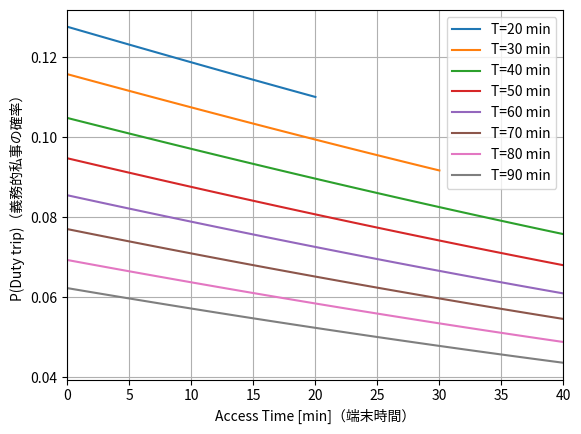

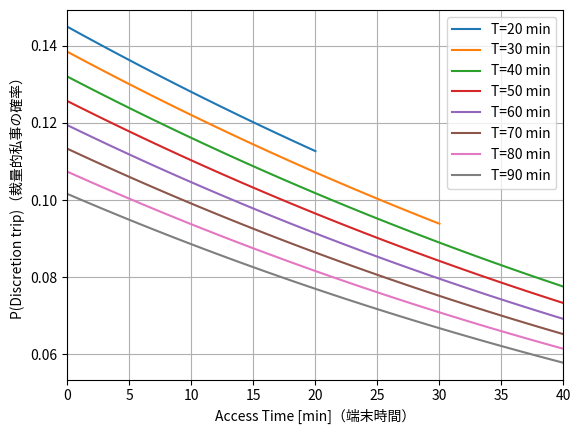

In [21]:
# 義務，裁量それぞれの確率の描画
# log( exp(0) + exp(x) + exp(y) ) を安定に計算
def logsumexp3_0xy(x, y):
    # = log(1 + exp(x) + exp(y))
    # まず logaddexp(0, x) = log(1 + exp(x)) を作り、それに y を足す
    return np.logaddexp(np.logaddexp(0.0, x), y)

def P_DU(a, T):
    iv_du = IV_DU(a, T)
    iv_di = IV_DI(a, T)
    denom_log = logsumexp3_0xy(iv_du, iv_di)
    return np.exp(iv_du - denom_log)

def P_DI(a, T):
    iv_du = IV_DU(a, T)
    iv_di = IV_DI(a, T)
    denom_log = logsumexp3_0xy(iv_du, iv_di)
    return np.exp(iv_di - denom_log)

def P_private_from_IV(a, T):
    # 念のため：P_private = P_DU + P_DI
    return P_DU(a, T) + P_DI(a, T)

# ========= 描画 =========
T_list = list(range(20, 91, 10))  # 20,30,...,90
x_max = 40

# --- Duty のみ ---
plt.figure()
for T in T_list:
    a_grid = np.arange(0, min(T, x_max) + 1)
    plt.plot(a_grid, P_DU(a_grid, T), label=f"T={T} min")
plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Access Time [min]（端末時間）")
plt.ylabel("P(Duty trip)（義務的私事の確率）")
plt.show()

# --- Discretion のみ ---
plt.figure()
for T in T_list:
    a_grid = np.arange(0, min(T, x_max) + 1)
    plt.plot(a_grid, P_DI(a_grid, T), label=f"T={T} min")
plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Access Time [min]（端末時間）")
plt.ylabel("P(Discretion trip)（裁量的私事の確率）")
plt.show()

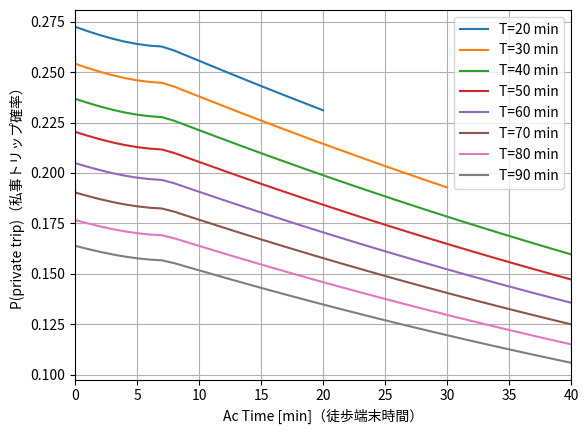

In [23]:
# 端末は徒歩を基準に他の手段も変化させ，通勤メイン時間を操作
import numpy as np
import matplotlib.pyplot as plt

# =========================================================
# 0) 推定パラメータとデータ（代表値計算用）
# =========================================================
b = results.get_beta_values()  # 推定パラメータ dict

# df を取得（master_db があればそれ、なければ master_df を使う）
try:
    df = master_db.dataframe
except NameError:
    df = master_df.copy()

def first_existing_column(df_, candidates):
    for c in candidates:
        if c in df_.columns:
            return c
    raise KeyError(f"None of these columns exist: {candidates}")

# =========================================================
# 1) 代表値（固定値）
#    ※ここは「解析式版」なので、個票の値は使わず代表値で固定します
# =========================================================
# AfterTime_work: 推定時に AF_WORKTIME_SCALED があれば優先
if "AF_WORKTIME_SCALED" in df.columns:
    AF_mean = float(df["AF_WORKTIME_SCALED"].mean())
else:
    col_af = first_existing_column(df, ["AfterTime_work[m]", "AfterTime_work"])
    AF_mean = float(df[col_af].mean()) / 60.0  # 分→時間

# NEKI: 推定時に NEKI_SCALED (= near_1000index2 / 10000) があれば優先
if "NEKI_SCALED" in df.columns:
    NEKI_mean = float(df["NEKI_SCALED"].mean())
else:
    col_neki = first_existing_column(df, ["near_1000index2"])
    # ★元モデルが /10_000 なのでこれに合わせる
    NEKI_mean = float(df[col_neki].mean()) / 10_000.0

# 世帯人数：例として 2 に固定（中央値にしたければ下の行を差し替え）
HHM_value = 2.0
# col_hhm = first_existing_column(df, ["HouseholdMembers(all)"])
# HHM_value = float(df[col_hhm].median())

# =========================================================
# 2) 相対差（徒歩との差）をデータから作る
#    ここを mean→median に変えると「中央値差分」を維持できます
# =========================================================
col_wa = first_existing_column(df, ["walk_time[m]"])
col_bi = first_existing_column(df, ["bicycle_time[m]"])
col_bu = first_existing_column(df, ["bus_time[m]"])
col_ca = first_existing_column(df, ["car_time[m]"])

delta_bi = float((df[col_bi] - df[col_wa]).mean())
delta_bu = float((df[col_bu] - df[col_wa]).mean())
delta_ca = float((df[col_ca] - df[col_wa]).mean())

# =========================================================
# 3) 数値安定用関数
# =========================================================
def sigmoid(z):
    z = np.asarray(z, dtype=float)
    out = np.empty_like(z)
    pos = z >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[~pos])
    out[~pos] = ez / (1.0 + ez)
    return out

def logsumexp2(a, b_):
    a = np.asarray(a, dtype=float)
    b_ = np.asarray(b_, dtype=float)
    m = np.maximum(a, b_)
    return m + np.log(np.exp(a - m) + np.exp(b_ - m))

def logsumexp4(x1, x2, x3, x4):
    m = np.maximum(np.maximum(x1, x2), np.maximum(x3, x4))
    return m + np.log(np.exp(x1 - m) + np.exp(x2 - m) + np.exp(x3 - m) + np.exp(x4 - m))

# =========================================================
# 4) モード側 logsum（端末時間はモード別：徒歩を動かし相対差を維持）
#    IV_m = Vpri_m + (1/mu_m)*log( sum_k exp(mu_m * V_mode_k) )
# =========================================================
def mode_logsum_term(mu, tt_wa, tt_bi, tt_bu, tt_ca):
    V_wa = b["b_at"] * tt_wa
    V_bi = b["ASC_BI"] + b["b_at"] * tt_bi
    V_bu = b["ASC_BU"] + b["b_at"] * tt_bu
    V_ca = b["ASC_CA"] + b["b_at"] * tt_ca

    # log(sum exp(mu*V_k))
    lse = logsumexp4(mu * V_wa, mu * V_bi, mu * V_bu, mu * V_ca)
    return (1.0 / mu) * lse

def IV_DU(a_walk, T):
    # 本線 = T - a_walk（分）
    main_scaled = (T - a_walk) / 60.0

    Vpri = (
        b["ASC_DU"]
        + b["b_aftime_work"] * AF_mean
        + b["b_macmtime_du"] * main_scaled
        + b["b_n_eki_du"] * NEKI_mean
        + b["b_hhm_du"] * HHM_value
    )

    mu = 1 / b["LAMBDA_DU"]

    # 相対差を維持して端末時間をモード別に生成
    tt_wa = a_walk
    tt_bi = np.maximum(0.0, a_walk + delta_bi)
    tt_bu = np.maximum(0.0, a_walk + delta_bu)
    tt_ca = np.maximum(0.0, a_walk + delta_ca)

    return Vpri + mode_logsum_term(mu, tt_wa, tt_bi, tt_bu, tt_ca)

def IV_DI(a_walk, T):
    main_scaled = (T - a_walk) / 60.0

    Vpri = (
        b["ASC_DI"]
        + b["b_aftime_work"] * AF_mean
        + b["b_macmtime_di"] * main_scaled
        + b["b_n_eki_di"] * NEKI_mean
        + b["b_hhm_di"] * HHM_value
    )

    mu = 1 / b["LAMBDA_DI"]

    tt_wa = a_walk
    tt_bi = np.maximum(0.0, a_walk + delta_bi)
    tt_bu = np.maximum(0.0, a_walk + delta_bu)
    tt_ca = np.maximum(0.0, a_walk + delta_ca)

    return Vpri + mode_logsum_term(mu, tt_wa, tt_bi, tt_bu, tt_ca)

def P_private(a_walk, T):
    # P(private) = (exp(IV_DU)+exp(IV_DI)) / (1 + exp(IV_DU)+exp(IV_DI))
    #           = sigmoid( log(exp(IV_DU)+exp(IV_DI)) )
    iv_du = IV_DU(a_walk, T)
    iv_di = IV_DI(a_walk, T)
    L = logsumexp2(iv_du, iv_di)
    return sigmoid(L)

# =========================================================
# 5) T×a をまとめて一括計算（行列計算）
# =========================================================
T_list = list(range(20, 91, 10))  # 20,30,...,90
x_max = 40                        # 徒歩端末 a は 0〜40 を表示

T_mat = np.array(T_list, dtype=float)[:, None]          # (nT,1)
A_mat = np.arange(0, x_max + 1, dtype=float)[None, :]  # (1,nA)

mask = A_mat <= T_mat  # a_walk <= T の領域だけ有効（本線が負にならない範囲）

P_mat = P_private(A_mat, T_mat)         # (nT,nA)
P_mat = np.where(mask, P_mat, np.nan)   # 範囲外は描画しない

# =========================================================
# 6) 描画
# =========================================================
plt.figure()
x = np.arange(0, x_max + 1)

for i, T in enumerate(T_list):
    plt.plot(x, P_mat[i, :], label=f"T={T} min")

plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Ac Time [min]（徒歩端末時間）")
plt.ylabel("P(private trip)（私事トリップ確率）")
plt.show()

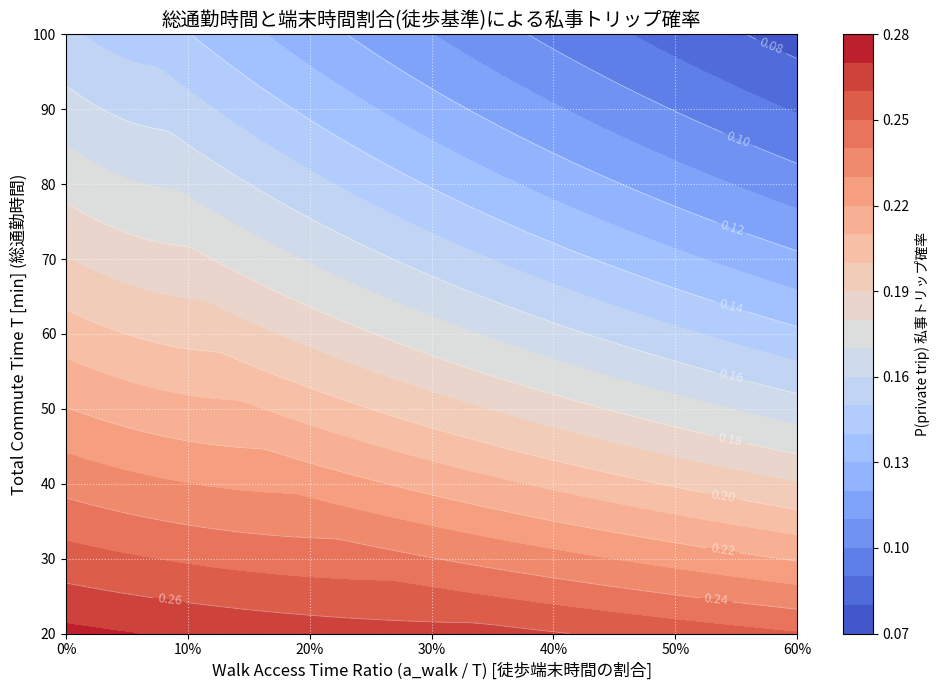

: 

In [ ]:
# =========================================================
# 0)〜4) まではご提示のコードと同じ定義を使用します
# =========================================================
# ※ ここに「推定パラメータ取得」「代表値計算」「関数定義(sigmoid, IV_DUなど)」
#    が含まれている前提とします。
#    （上で提示されたコードの def P_private までをそのまま実行してください）

# =========================================================
# 5) ヒートマップ用データの作成
# =========================================================
# 縦軸：総通勤時間 T (20分〜100分)
T_vals = np.linspace(20, 100, 100)

# 横軸：端末時間の割合 Ratio (0.0 〜 1.0)
# ここでは「徒歩時間(a_walk)」の割合として定義します
R_vals = np.linspace(0, 0.6, 100)

# 格子点（メッシュ）を作成
RR, TT = np.meshgrid(R_vals, T_vals)

# 格子点ごとの「徒歩端末時間 a_walk」を計算
# a_walk = 総時間 T * 割合 Ratio
AA_walk = TT * RR

# 格子点ごとの「私事トリップ確率」を計算
# ※ご提示の関数内で他モードの時間(tt_biなど)は a_walk + delta で自動計算されます
PP = P_private(AA_walk, TT)

# =========================================================
# 6) 描画：ヒートマップ（等高線充填）
# =========================================================
plt.figure(figsize=(10, 7))

# --- 色付き等高線 (Heatmap) ---
# levels=20 で色の階調を細かくしています
cp = plt.contourf(RR, TT, PP, levels=20, cmap='coolwarm')

# --- 白い等高線 (Contours) ---
# 確率の値を読み取りやすくするために線を重ねます
line_c = plt.contour(RR, TT, PP, levels=10, colors='white', alpha=0.5, linewidths=0.5)
plt.clabel(line_c, inline=True, fontsize=9, fmt='%.2f') # 線上に数値を表示

# --- 軸・ラベル設定 ---
# 横軸をパーセント表示に
plt.gca().xaxis.set_major_formatter(ticker.PercentFormatter(1.0))

plt.colorbar(cp, label='P(private trip) 私事トリップ確率')

plt.title("総通勤時間と端末時間割合(徒歩基準)による私事トリップ確率", fontsize=14)
plt.xlabel("Walk Access Time Ratio (a_walk / T) [徒歩端末時間の割合]", fontsize=12)
plt.ylabel("Total Commute Time T [min] (総通勤時間)", fontsize=12)

# グリッド線
plt.grid(True, linestyle=':', alpha=0.6, color='white')

plt.tight_layout()
plt.show()

In [16]:
# 徒歩時間の変動による各モードの平均差分を維持したときの私事トリップ確率の変化
from biogeme.expressions import log  # Biogemeのlog（expression用）

# =========================
# 前提：推定済みオブジェクト
# =========================
# results, master_db, V, av, nests
# 代替ID: NO, DU_WA, DU_BI, DU_BU, DU_CA, DI_WA, DI_BI, DI_BU, DI_CA

betas = results.get_beta_values()
df = master_db.dataframe

# =========================
# 1) 必要な確率の式を作る
# =========================
P_NO = nested(V, av, nests, NO)

P_DU_WA = nested(V, av, nests, DU_WA)
P_DI_WA = nested(V, av, nests, DI_WA)

P_DU = sum(nested(V, av, nests, a) for a in [DU_WA, DU_BI, DU_BU, DU_CA])
P_DI = sum(nested(V, av, nests, a) for a in [DI_WA, DI_BI, DI_BU, DI_CA])

P_PRIVATE = 1.0 - P_NO

# 安全策（ゼロ割回避）：理論上DU/DIはwalkがあるので>0のはずですが保険
EPS = 1e-300
P_DU_safe = P_DU + EPS
P_DI_safe = P_DI + EPS
P_NO_safe = P_NO + EPS

P_WA_given_DU = P_DU_WA / P_DU_safe
P_WA_given_DI = P_DI_WA / P_DI_safe

# Inclusive value を確率から逆算（上位が {NO,DU,DI} のロジットになるので厳密）
IV_DU = log(P_DU_safe / P_NO_safe)
IV_DI = log(P_DI_safe / P_NO_safe)

simulate_dict = {
    "P_private": P_PRIVATE,
    "P_NO": P_NO,
    "P_DU": P_DU,
    "P_DI": P_DI,
    "P_WA_given_DU": P_WA_given_DU,
    "P_WA_given_DI": P_WA_given_DI,
    "IV_DU": IV_DU,
    "IV_DI": IV_DI,
}

logger = blog.get_screen_logger(level=blog.INFO)
biosim = BIOGEME(master_db, simulate_dict)
biosim.model_name = "sim_diag_private"

# =========================
# 2) 「徒歩以外は中央値固定」設定（必要ならあなたの値に合わせて変更）
# =========================
bike_med = float(df["bicycle_time[m]"].median())
bus_med  = float(df["bus_time[m]"].median())
car_med  = float(df["car_time[m]"].median())

bike_fix, bus_fix, car_fix = max(0.0, bike_med), max(0.0, bus_med), max(0.0, car_med)

# =========================
# 3) 感度分析ループ
# =========================
T_list = list(range(20, 91, 10))  # 20,30,...,90
x_max = 40

# ループ総回数を先に計算
total_steps = sum(min(T, x_max) + 1 for T in T_list)

step = 0
t0 = time.time()
t_last = t0

print(f"Total scenarios: {total_steps}")

time_cols = ["walk_time[m]", "bicycle_time[m]", "bus_time[m]", "car_time[m]", "MainlineTime[m]"]
backup = df[time_cols].copy()

has_macm_scaled = "MACMTIME_SCALED" in df.columns
if has_macm_scaled:
    backup_macm_scaled = df["MACMTIME_SCALED"].copy()

rows = []

try:
    for T in T_list:
        for a_walk in range(0, min(T, x_max) + 1):
            mainline = T - a_walk

            # 徒歩だけ動かす、他は中央値固定
            df["walk_time[m]"]    = a_walk
            df["bicycle_time[m]"] = bike_fix
            df["bus_time[m]"]     = bus_fix
            df["car_time[m]"]     = car_fix
            df["MainlineTime[m]"] = mainline

            if has_macm_scaled:
                df["MACMTIME_SCALED"] = df["MainlineTime[m]"] / 60.0

            sim = biosim.simulate(betas)  # 各観測の値（DataFrame）

            rows.append({
                "T": T,
                "walk": a_walk,
                # ここでは平均だけ保存（必要なら分位も追加できます）
                "P_private_mean": float(sim["P_private"].mean()),
                "P_NO_mean": float(sim["P_NO"].mean()),
                "P_DU_mean": float(sim["P_DU"].mean()),
                "P_DI_mean": float(sim["P_DI"].mean()),
                "P_WA_given_DU_mean": float(sim["P_WA_given_DU"].mean()),
                "P_WA_given_DI_mean": float(sim["P_WA_given_DI"].mean()),
                "IV_DU_mean": float(sim["IV_DU"].mean()),
                "IV_DI_mean": float(sim["IV_DI"].mean()),
            })

            # 進捗ログの表示
            if step == 1 or step == total_steps or step % 10 == 0:
                now = time.time()
                elapsed = now - t0

                # 直近区間の平均（直近10回ごとに近い）
                dt = now - t_last
                t_last = now

                # 速度とETA
                rate = step / elapsed if elapsed > 0 else float("inf")  # cases/sec
                eta = (total_steps - step) / rate if rate > 0 else float("inf")

                print(
                    f"[{step:4d}/{total_steps}] "
                    f"T={T:2d}, walk={a_walk:2d} | "
                    f"elapsed={elapsed:7.1f}s | "
                    f"ETA={eta:7.1f}s | "
                    f"recent_dt={dt:5.2f}s"
                )

finally:
    df[time_cols] = backup
    if has_macm_scaled:
        df["MACMTIME_SCALED"] = backup_macm_scaled

df_diag = pd.DataFrame(rows)

# =========================
# 4) 図の例：P(private)（あなたが作った図と同じ）
# =========================
plt.figure()
for T in T_list:
    sub = df_diag[df_diag["T"] == T].sort_values("walk")
    plt.plot(sub["walk"], sub["P_private_mean"], label=f"T={T} min")
plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Walk terminal time a (min)")
plt.ylabel("Mean P(private trip) = 1 - P(NoTrip)")
plt.show()

# =========================
# 5) 原因確認の図（例）：P(WA|DU) と P(WA|DI)
#    ※線が多いので、まずは1つのTだけ描く例にしています
# =========================
T_pick = 40  # 見たいTに変更
sub = df_diag[df_diag["T"] == T_pick].sort_values("walk")

plt.figure()
plt.plot(sub["walk"], sub["P_WA_given_DU_mean"], label=f"P(WA|DU), T={T_pick}")
plt.plot(sub["walk"], sub["P_WA_given_DI_mean"], label=f"P(WA|DI), T={T_pick}")
plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Walk terminal time a (min)")
plt.ylabel("Mean conditional probability")
plt.show()

# =========================
# 6) 原因確認の図（例）：IV_DU と IV_DI（上位効用の代理指標）
# =========================
plt.figure()
plt.plot(sub["walk"], sub["IV_DU_mean"], label=f"IV_DU, T={T_pick}")
plt.plot(sub["walk"], sub["IV_DI_mean"], label=f"IV_DI, T={T_pick}")
plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Walk time [min]（徒歩時間）")
plt.ylabel("P(private trip)（私事トリップ確率）")
plt.show()

Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 


Total scenarios: 298
[   0/298] T=20, walk= 0 | elapsed=  167.7s | ETA=    infs | recent_dt=167.71s
[   0/298] T=20, walk= 1 | elapsed=  297.2s | ETA=    infs | recent_dt=129.53s
[   0/298] T=20, walk= 2 | elapsed=  422.0s | ETA=    infs | recent_dt=124.71s
[   0/298] T=20, walk= 3 | elapsed=  550.0s | ETA=    infs | recent_dt=128.06s
[   0/298] T=20, walk= 4 | elapsed=  690.1s | ETA=    infs | recent_dt=140.06s
[   0/298] T=20, walk= 5 | elapsed=  834.9s | ETA=    infs | recent_dt=144.80s
[   0/298] T=20, walk= 6 | elapsed=  979.0s | ETA=    infs | recent_dt=144.16s
[   0/298] T=20, walk= 7 | elapsed= 1121.5s | ETA=    infs | recent_dt=142.45s
[   0/298] T=20, walk= 8 | elapsed= 1243.7s | ETA=    infs | recent_dt=122.26s


KeyboardInterrupt: 

Biogeme parameters read from biogeme.toml. 
Biogeme parameters read from biogeme.toml. 


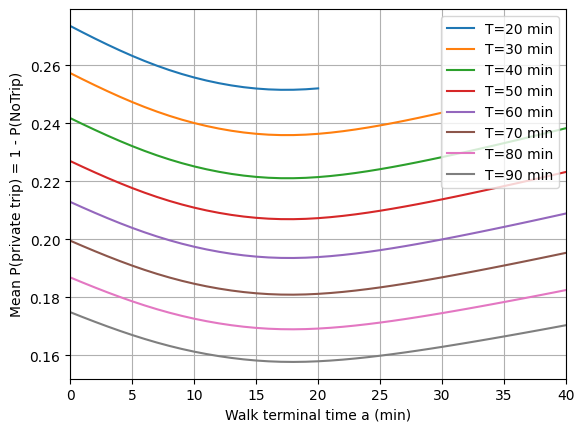

In [ ]:
# 徒歩のみ変動させた場合の感度分析（全データに対するシミュレーション型）
from biogeme.models import nested

# =========================
# 0) 推定済みパラメータ
# =========================
betas = results.get_beta_values()

# =========================
# 1) 私事確率の式：P(private)=1-P(NO)
# =========================
P_no_expr = nested(V, av, nests, NO)
P_private_expr = 1.0 - P_no_expr

simulate_dict = {"P_private": P_private_expr}

logger = blog.get_screen_logger(level=blog.INFO)
biosim = BIOGEME(master_db, simulate_dict)
biosim.model_name = "sim_private_prob"

# =========================
# 2) データフレーム参照（Biogeme 3.3系）
# =========================
df = master_db.dataframe

# =========================
# 3) 徒歩以外の端末時間を「中央値」で固定
#    ※欠損がある場合は median() が NaN になることがあるので注意
# =========================
bike_med = float(df["bicycle_time[m]"].median())
bus_med  = float(df["bus_time[m]"].median())
car_med  = float(df["car_time[m]"].median())

def fixed_nonwalk_times():
    """徒歩以外は中央値で固定（負値があり得るなら0で下限処理）"""
    return max(0.0, bike_med), max(0.0, bus_med), max(0.0, car_med)

# =========================
# 4) 感度分析設定
# =========================
T_list = list(range(20, 91, 10))  # 20,30,...,90
x_max = 40                        # 図の表示上限（必要に応じて変更）

# 変更する列を退避して、最後に必ず元に戻す
time_cols = ["walk_time[m]", "bicycle_time[m]", "bus_time[m]", "car_time[m]", "MainlineTime[m]"]
backup = df[time_cols].copy()

# define_variableで作った列は自動更新されないことがあるので、存在すれば更新対象にする
has_macm_scaled = "MACMTIME_SCALED" in df.columns
if has_macm_scaled:
    backup_macm_scaled = df["MACMTIME_SCALED"].copy()

rows = []

try:
    bike_fix, bus_fix, car_fix = fixed_nonwalk_times()

    for T in T_list:
        # 徒歩端末時間 a を 1分刻みで 0..min(T, x_max)
        for a_walk in range(0, min(T, x_max) + 1):
            mainline = T - a_walk  # 本線時間（分）

            # 徒歩だけ変更、他モードは中央値固定
            df["walk_time[m]"]    = a_walk
            df["bicycle_time[m]"] = bike_fix
            df["bus_time[m]"]     = bus_fix
            df["car_time[m]"]     = car_fix

            df["MainlineTime[m]"] = mainline

            # スケール列があるなら更新（あなたのモデルは MACMTIME_SCALED を使っている）
            if has_macm_scaled:
                df["MACMTIME_SCALED"] = df["MainlineTime[m]"] / 60.0

            # 各観測の P_private を計算 → 母集団平均
            sim_df = biosim.simulate(betas)
            p_mean = float(sim_df["P_private"].mean())

            rows.append({"T": T, "walk": a_walk, "P_private_mean": p_mean})

finally:
    # 元のデータに必ず戻す
    df[time_cols] = backup
    if has_macm_scaled:
        df["MACMTIME_SCALED"] = backup_macm_scaled

df_sens = pd.DataFrame(rows)

# =========================
# 5) プロット
# =========================
plt.figure()
for T in T_list:
    sub = df_sens[df_sens["T"] == T].sort_values("walk")
    plt.plot(sub["walk"], sub["P_private_mean"], label=f"T={T} min")

plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Walk time [min]（徒歩時間）")
plt.ylabel("P(private trip)（私事トリップ確率）")
plt.show()

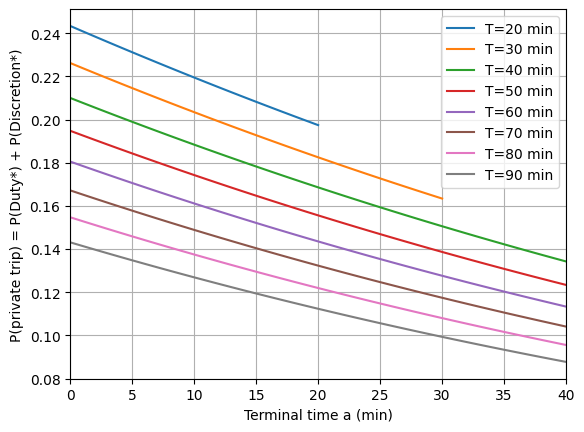

In [ ]:
# 端末徒歩だけを変化させた場合
# ========= 1) 推定値の読み込み =========
b = results.get_beta_values()  # dict: 推定パラメータ

# 便利関数：安定な sigmoid
def sigmoid(z):
    z = np.asarray(z)
    out = np.empty_like(z, dtype=float)
    pos = z >= 0
    out[pos] = 1.0 / (1.0 + np.exp(-z[pos]))
    ez = np.exp(z[~pos])
    out[~pos] = ez / (1.0 + ez)
    return out

# log(exp(a)+exp(b)) を安定に計算
def logsumexp2(a, b):
    m = np.maximum(a, b)
    return m + np.log(np.exp(a - m) + np.exp(b - m))

# ========= 2) 平均値で固定する共変量 =========
df = master_db.dataframe

# scaled列があるならそれを優先、無ければ元列から計算
AF_mean = df["AF_WORKTIME_SCALED"].mean() if "AF_WORKTIME_SCALED" in df.columns else (df["AfterTime_work[m]"].mean() / 60.0)
NEKI_mean = df["NEKI_SCALED"].mean() if "NEKI_SCALED" in df.columns else (df["near_1000index2"].mean() / 10_000.0)
HHM_mean = df["HouseholdMembers(all)"].mean() if "HouseholdMembers(all)" in df.columns else df["HHM_all"].mean()

# ========= 3) モード側 logsum 部分（端末時間 a を全モード共通に置く仮定） =========
# V_mode_WA = b_at * a
# V_mode_BI = ASC_BI + b_at * a, etc.
# sum_k exp(mu*(ASC_k + b_at*a)) = exp(mu*b_at*a) * (1 + exp(mu*ASC_BI)+exp(mu*ASC_BU)+exp(mu*ASC_CA))
# (1/mu)*log(sum...) = b_at*a + (1/mu)*log(1 + exp(mu*ASC_BI)+exp(mu*ASC_BU)+exp(mu*ASC_CA))

def mode_logsum_term(mu, a):
    S = (
        1.0
        + np.exp(mu * b["ASC_BI"])
        + np.exp(mu * b["ASC_BU"])
        + np.exp(mu * b["ASC_CA"])
    )
    return b["b_at"] * a + (1.0 / mu) * np.log(S)

# ========= 4) Inclusive value IV_DU, IV_DI =========
# 本線時間 = T - a（分）→ MACMTIME_SCALED = (T-a)/60
def IV_DU(a, T):
    main_scaled = (T - a) / 60.0
    Vpri = (
        b["ASC_DU"]
        + b["b_aftime_work_du"] * AF_mean
        + b["b_macmtime_du"] * main_scaled
        + b["b_n_eki_du"] * NEKI_mean
        + b["b_hhm_du"] * HHM_mean
    )
    mu = b["MU_DU"]
    return Vpri + mode_logsum_term(mu, a)

def IV_DI(a, T):
    main_scaled = (T - a) / 60.0
    Vpri = (
        b["ASC_DI"]
        + b["b_aftime_work_di"] * AF_mean
        + b["b_macmtime_di"] * main_scaled
        + b["b_n_eki_di"] * NEKI_mean
        + b["b_hhm_di"] * HHM_mean
    )
    mu = b["MU_DI"]
    return Vpri + mode_logsum_term(mu, a)

# ========= 5) P(private)=P(DU)+P(DI) =========
# P(private) = (exp(IV_DU)+exp(IV_DI)) / (1 + exp(IV_DU)+exp(IV_DI))
#           = sigmoid( log(exp(IV_DU)+exp(IV_DI)) )
def P_private(a, T):
    iv_du = IV_DU(a, T)
    iv_di = IV_DI(a, T)
    L = logsumexp2(iv_du, iv_di)   # = log( exp(IV_DU)+exp(IV_DI) )
    return sigmoid(L)

# ========= 6) 描画 =========
T_list = list(range(20, 91, 10))  # 20,30,...,90
x_max = 40                        # 図に合わせて 0〜40 分を表示

plt.figure()
for T in T_list:
    a_grid = np.arange(0, min(T, x_max) + 1)  # a=0..min(T,40)
    p_grid = P_private(a_grid, T)
    plt.plot(a_grid, p_grid, label=f"T={T} min")

plt.xlim(0, x_max)
plt.grid(True)
plt.legend()
plt.xlabel("Terminal time a (min)")
plt.ylabel("P(private trip) = P(Duty*) + P(Discretion*)")
plt.show()